# Burst Detection
This notebook shows how to use `neurodsp.burst` to determine the portions of a signal that contain a burst of an oscillation of interest.

In [2]:
import numpy as np
from neurodsp.sim import sim_noisy_bursty_oscillator
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

### Simulate a signal with a bursting oscillation with noise
First, we'll simulate bursting activity in the alpha range on top of some background noise.

(0, 5)

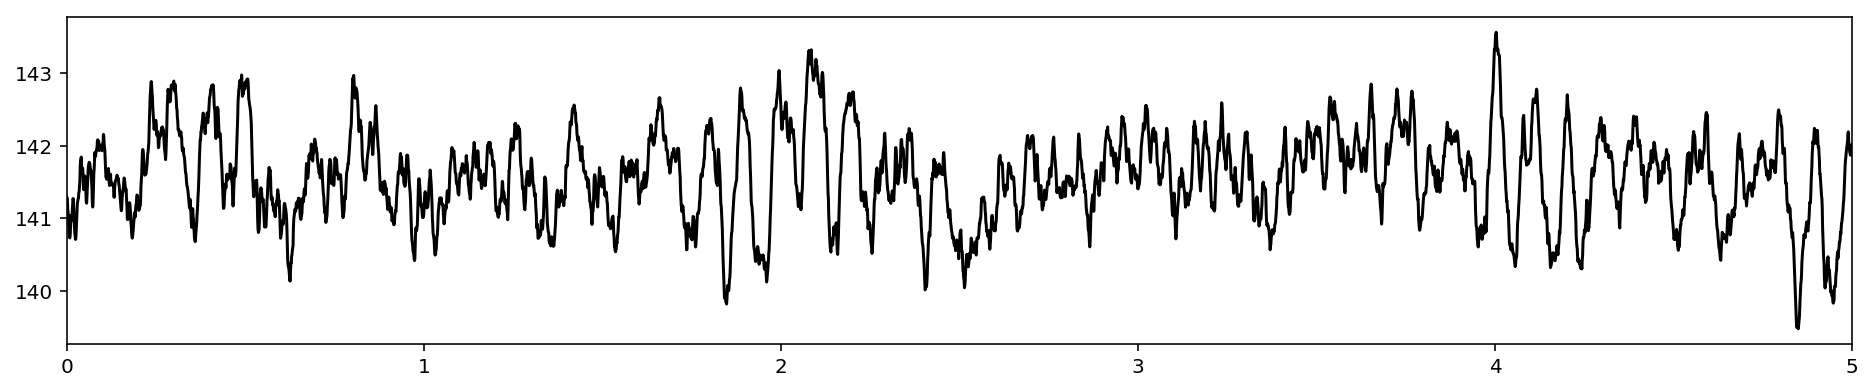

In [3]:
# Generate quasi-periodic data with an alpha burst
np.random.seed(1)

n_seconds = 5
fs = 1000
freq = 10
f_range = (8, 12)

noise_model = 'synaptic'
noise_args = {'n_neurons':1000, 'firing_rate':2, 't_ker':1.0, 'tau_r':0.002, 'tau_d':0.02}

sig = sim_noisy_bursty_oscillator(n_seconds, fs, freq, noise_model, noise_args, ratio_osc_var=2., prob_enter_burst=.2, prob_leave_burst=.2,)
t = np.arange(0, n_seconds, 1/fs)

plt.figure(figsize=(16,3))
plt.plot(t, sig, 'k', label='simulated EEG')
plt.xlim((0, n_seconds))

We can see that 10Hz oscillations present 1.5-2.1 seconds and after 4.2 seconds.

### Dual ampliturde threshold algorithm

This algorithm first computes the amplitude at each point in time for a given frequency range. This amplitude is then normalized by the average (default: median) amplitude of the whole time series. Two thresholds are defined based off of this normalized amplitude. In order for a burst to be detected, the amplitude must cross the higher amplitude threshold. The burst lasts until the amplitude then falls below the lower amplitude threshold.
  
**Other Parameters:**
* The average for normalization can be set to either the mean or median by modifying the `average_method` keyword argument. 
* Power can be used instead of amplitude by modifying the `magnitude_type` keyword argument.

Transition bandwidth is 2.9 Hz. Pass/stop bandwidth is 4 Hz


/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


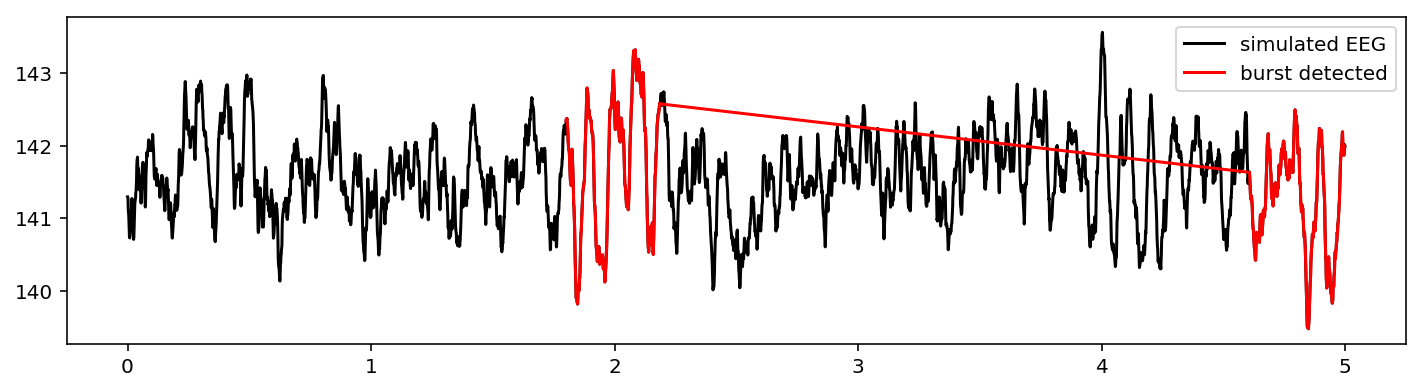

In [4]:
# Detect bursts using 'deviation' algorithm
amp_dual_thresh = (1, 2)
bursting = detect_bursts_dual_threshold(sig, fs, f_range, amp_dual_thresh)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, sig, 'k', label='simulated EEG');
plt.plot(t[bursting], sig[bursting], 'r', label='burst detected')
plt.legend(loc='best');

The graph above shows the bursting activity in red. The Deviation algorithm was used with thresh=(1, 2), so any time point with more than 3 times the median magnitude in the alpha range (8-12 Hz) was marked as bursting activity.  

### Burst detection applied to real recordings

Transition bandwidth is 2.9 Hz. Pass/stop bandwidth is 4 Hz


/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


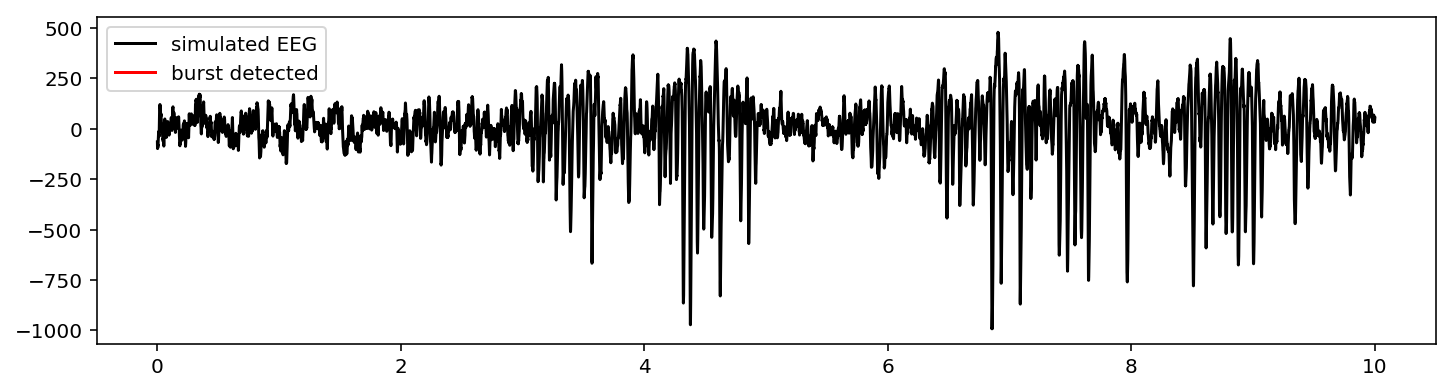

In [6]:
# Load data
sig = np.load('./data/sample_data_1.npy')
fs = 1000

# Same code as earlier
t = np.arange(0, len(sig)/fs, 1/fs)

# Detect bursts using 'deviation' algorithm
bursting = detect_bursts_dual_threshold(sig, fs, f_range, dual_thresh=(3, 3))

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, sig, 'k', label='simulated EEG');
plt.plot(t[bursting], sig[bursting], 'r', label='burst detected')
plt.legend(loc='best');

No bursts were detected! There could be a number of reasons for this. One of the easy things to do is to adjust the parameters for burst detection. Let's try making the thresholds lower.

Transition bandwidth is 2.9 Hz. Pass/stop bandwidth is 4 Hz


/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


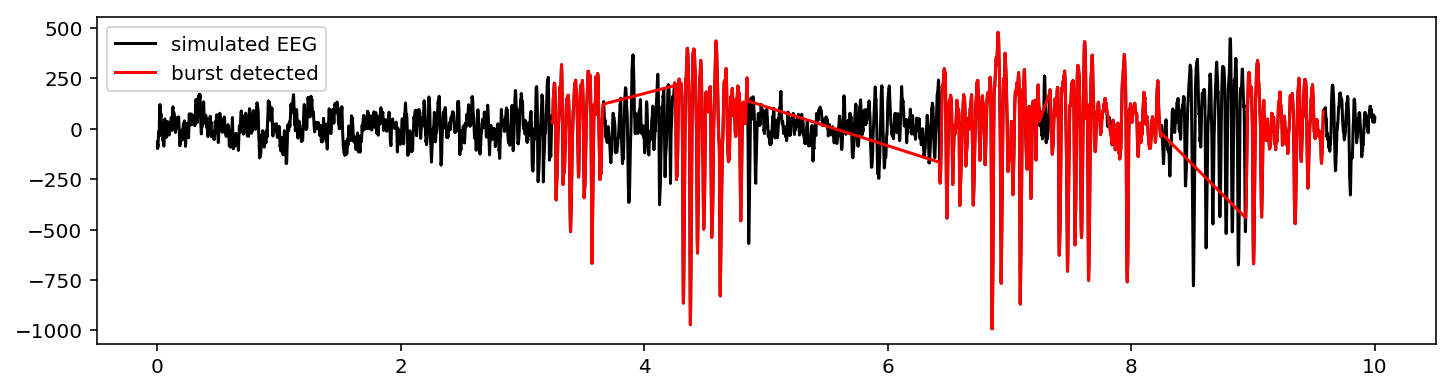

In [7]:
# Detect bursts using 'deviation' algorithm
bursting = detect_bursts_dual_threshold(sig, fs, f_range, dual_thresh=(1, 2))

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, sig, 'k', label='simulated EEG');
plt.plot(t[bursting], sig[bursting], 'r', label='burst detected')
plt.legend(loc='best');

Better, but not very good. Note the undetected cycles just before 9s. 

There's another serious issue: we're looking for alpha bursts, but the bursts in this data are *beta* bursts.  

Transition bandwidth is 5.9 Hz. Pass/stop bandwidth is 17 Hz


/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


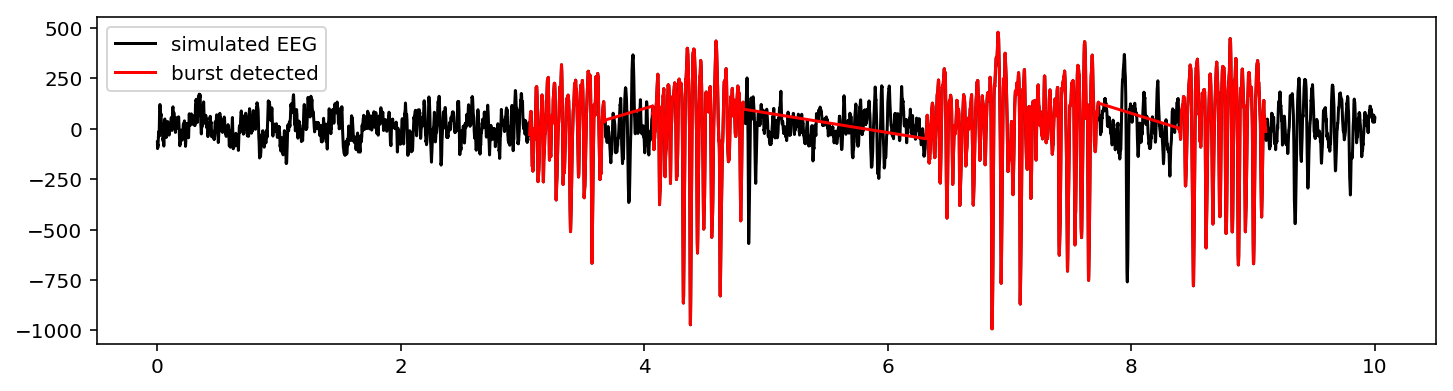

In [8]:
# Detect bursts using 'deviation' algorithm
bursting = detect_bursts_dual_threshold(sig, fs, (13, 30), dual_thresh=(1, 2))

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, sig, 'k', label='simulated EEG');
plt.plot(t[bursting], sig[bursting], 'r', label='burst detected')
plt.legend(loc='best');

Much better! This just goes to show that burst detection is an art that requires some knowledge of the data you're working with.